# KNN으로 하는 당뇨병 에측하기!
이번에는 같은 데이터를 가지고 다른 분류모델인 KNN을 사용해서 분리를 해보도록 하겠습니다.

# 패키지 import

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import seaborn as sns

# 데이터 준비하기

## 데이터 읽기

In [2]:
data_pandas = pd.read_csv("./regression/data/diabetes.csv")
display(data_pandas)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


## 데이터에 불순물 없나 체크하기

isnull을 통해서 빈값이 있나 확인해봅니다.

In [3]:
print(data_pandas.isnull().sum())

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


### 만일 데이터에 빈 값이 있다면 fillna 함수를 이용해서 채울 수 있습니다.
* `inplace`는 데이터에 직접 삽입하는 옵션입니다.(복사 없이)  
* `mean`은 평균을 `median`은 데이터를 정렬했을 때 중앙에 위치한 값입니다. (중위수라고도 불립니다. 걍 중점입니다.)
>```python
>data_pandas['Glucose'].fillna(diabetes_data_copy['Glucose'].mean(), inplace = True)
>data_pandas['BMI'].fillna(diabetes_data_copy['BMI'].median(), inplace = True)
>```

아래 그래프는 각 속성별 히스토그램입니다. 히스토그램은 범위에 속하는 데이터들의 갯수를 세서 세로축에 표시하는 것으로   데이터의 분포도를 알 수 있습니다. BMI, Insulin, SkinThickness, Pregnancies 등의 속성은 데이터가 고르지 못하고 치우쳐져 있기 때문에 중앙값을 채워넣고 비교적 고르게 분포되어있는 Glucose는 산술평균값을 채워넣는 것이 좋습니다.  

정리하면, 데이터 분포가 고를 때는 평균값을 쓰는것이 좋고 아닐 때는 중앙값을 쓰는 것이 좋습니다.  
그러나 이것이 항상 옳은 것은 아닙니다. 단순한 분석보다 우리가 분석을 통해서 의사결정을 할 때는 더 유리하고 더 연관성있는 값을 쓰는것이 좋습니다.

**참고**
[Mean or median? Choose based](https://towardsdatascience.com/mean-or-median-choose-based-on-the-decision-not-the-distribution-f951215c1376?gi=c697fbb56db9)

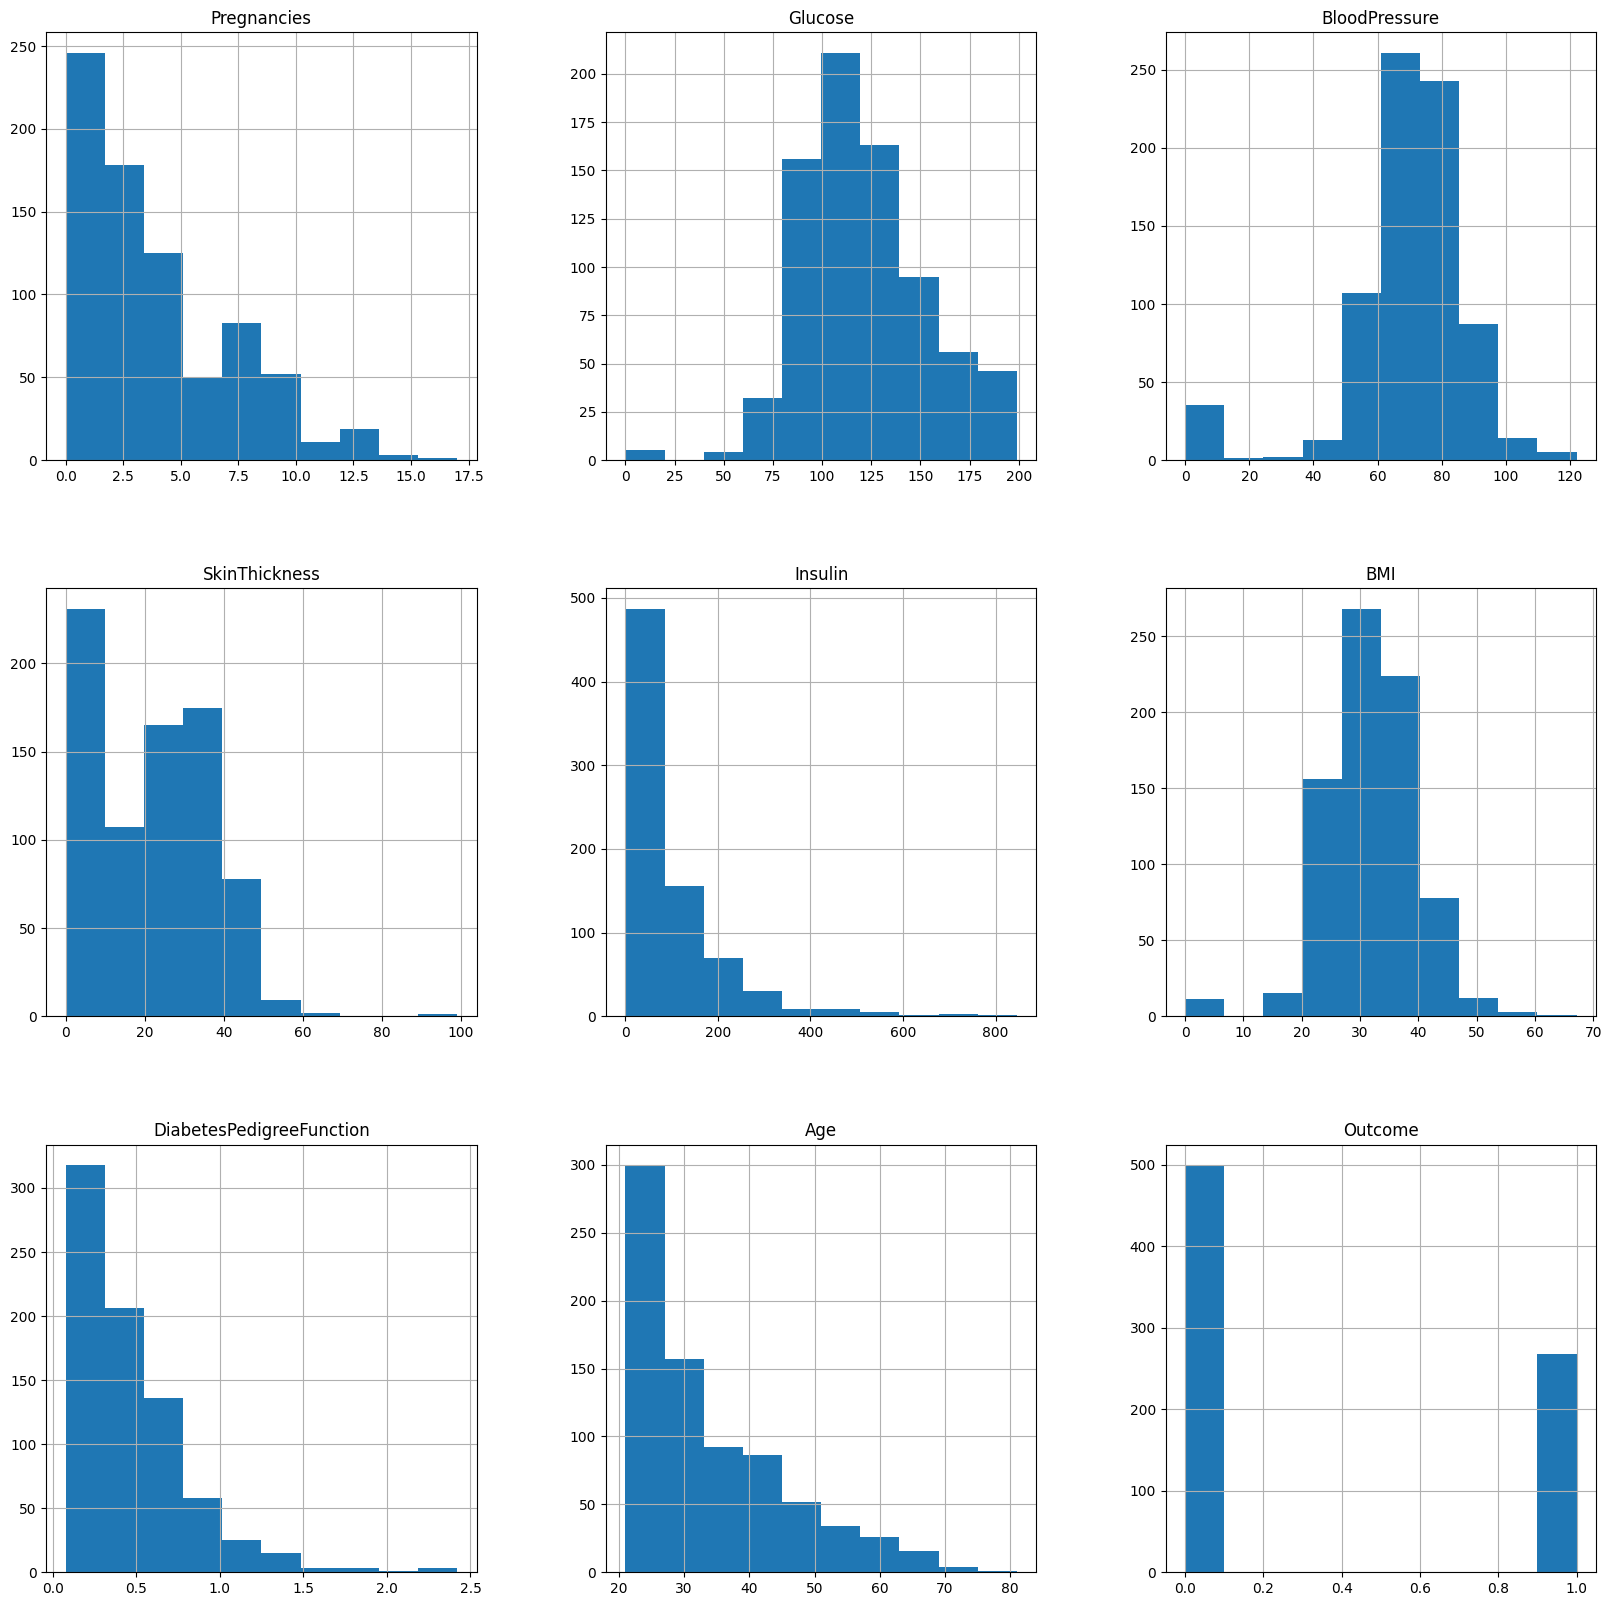

In [4]:
p = data_pandas.hist(figsize = (20,20))

## 상관관계 확인하기
상관관계를 온도로 표시한 히트맵을 통해서 각 독립변수들간의 큰 상관관계 없는지, 그래서 drop시켜야 할 변수가 없는지 확인합니다.

<Axes: >

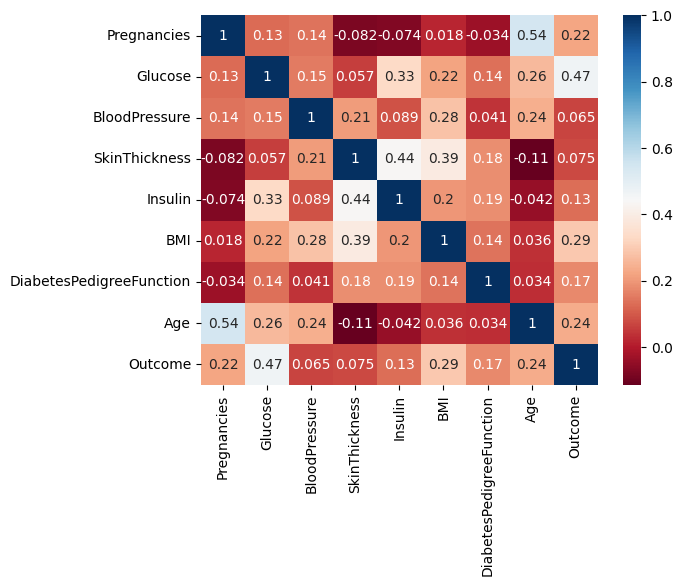

In [5]:
sns.heatmap(data_pandas.corr(), annot=True,cmap ='RdBu')

## 정규화 해주기

In [5]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
data_pandas.loc[:, data_pandas.columns!='Outcome'] = min_max_scaler.fit_transform(data_pandas.loc[:, data_pandas.columns!='Outcome'])
print(data_pandas)

     Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0       0.352941  0.743719       0.590164       0.353535  0.000000  0.500745   
1       0.058824  0.427136       0.540984       0.292929  0.000000  0.396423   
2       0.470588  0.919598       0.524590       0.000000  0.000000  0.347243   
3       0.058824  0.447236       0.540984       0.232323  0.111111  0.418778   
4       0.000000  0.688442       0.327869       0.353535  0.198582  0.642325   
..           ...       ...            ...            ...       ...       ...   
763     0.588235  0.507538       0.622951       0.484848  0.212766  0.490313   
764     0.117647  0.613065       0.573770       0.272727  0.000000  0.548435   
765     0.294118  0.608040       0.590164       0.232323  0.132388  0.390462   
766     0.058824  0.633166       0.491803       0.000000  0.000000  0.448584   
767     0.058824  0.467337       0.573770       0.313131  0.000000  0.453055   

     DiabetesPedigreeFunction       Age

## 학습데이터와 검증 데이터 분리하기

In [6]:
from sklearn.model_selection import train_test_split
X = data_pandas.loc[:, data_pandas.columns != 'Outcome']
Y = data_pandas.loc[:, data_pandas.columns == 'Outcome']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

# 학습하기

In [7]:
from sklearn.neighbors import KNeighborsClassifier

test_scores = []
train_scores = []

for i in range(1,15):

    knn = KNeighborsClassifier(i)
    knn.fit(X_train, Y_train)
    
    train_scores.append(knn.score(X_train, Y_train))
    test_scores.append(knn.score(X_test, Y_test))

print(np.max(train_scores))
print(np.max(test_scores))

/home/dsparch/KIRO/.venv/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/dsparch/KIRO/.venv/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/dsparch/KIRO/.venv/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/dsparch/KIRO/.venv/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expe

1.0
0.8095238095238095


/home/dsparch/KIRO/.venv/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/dsparch/KIRO/.venv/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/dsparch/KIRO/.venv/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/dsparch/KIRO/.venv/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expe

## 어떤 K가 가장 최적의 K인지 확인해보기
스코어가 train과 test가 가장 비슷면서 score값이 높은 것이 최적이 K 값이 됩니다.
즉 아래 그래프에서는 k=5인 모델이 가장 성능이 좋은 모델이라고 할 수 있습니다.

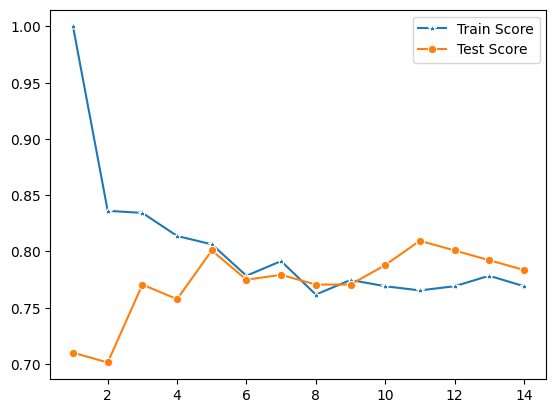

In [8]:
plt.figure()
sns.lineplot(x=range(1,15), y=train_scores, marker='*',label='Train Score')
sns.lineplot(x=range(1,15), y=test_scores, marker='o',label='Test Score')
plt.show()

In [11]:
## 데이터 넣고 테스트 해보기
knn = KNeighborsClassifier(5)
knn.fit(X_train, Y_train)

x_test = np.array([[6, 148, 72, 35, 0, 33.6, 0.627, 50]])

# 정답은 1 입니다.
y_predict = knn.predict(x_test)
print(y_predict)

[1]


/home/dsparch/KIRO/.venv/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/dsparch/KIRO/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
